In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import math
import math
import random
import scipy.stats as stats
#matplotlib.rcParams['text.usetex'] = True
import seaborn as sns
from simtk.unit import *

kb = BOLTZMANN_CONSTANT_kB * kilojoules_per_mole

sns.set()

%matplotlib inline

Starting pos - 17.140000
(61000,) 61000 (45, 2)
6.02214179e+23 /mol


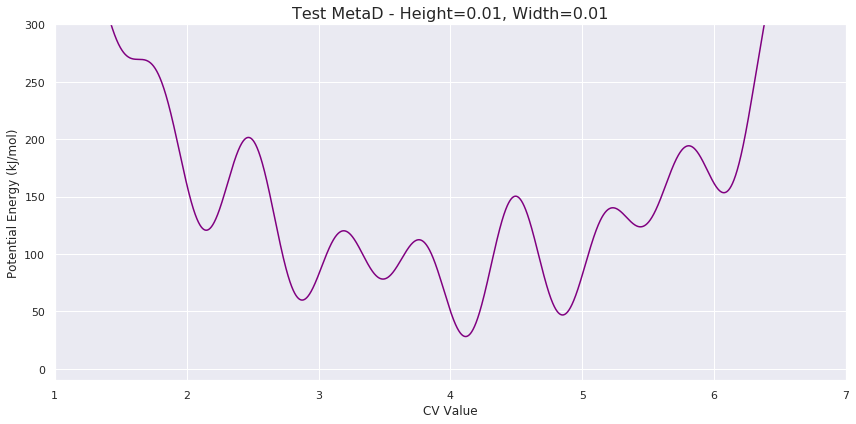

In [23]:
np.set_printoptions(precision=4)

#Setting up grid of X values
min_val = -30.5
max_val = 30.5

temperature = 300*kelvin

valrange = max_val - min_val
increment = 0.001
npoints = int(valrange/increment)

x = np.linspace(min_val, max_val, npoints)
x = np.around(x, decimals=3)

#Build the triple well potential
vals = [4.5, 0.8, 6, 1.0, 7.0, 7.0]
q = (2*math.pi)/vals[3]
#potential = [math.exp(x[i] - 27) + math.exp(4 - x[i]) + 6*(A[0]*math.cos((1/1.0)*q*(x[i])) + A[1]*math.cos(-1/2.5*q*x[i]) + A[2]*math.sin((1/2.5)*q*x[i]) + 6) 
#      for i in np.arange(0, len(x))]

potential = [math.exp(x[i] - 1.0) + math.exp(vals[4] - x[i])
             + 6*(vals[0]*math.cos(q*x[i] + math.pi) + 
                  vals[1]*math.cos(1.5*q*x[i] + math.pi) + 
                  vals[2]*math.sin(1.5*q*x[i] + math.pi) + vals[5])
      for i in np.arange(0, len(x))]

#(1/(x[i]-min_val)) - (1/(x[i] - max_val)) +

delta_pot = [(-6*math.pi*(5*math.sin(q*x[i]) + 9*math.sin(1.5*q*x[i]) - 10*math.cos(1.5*q*x[i])))
             for i in np.arange(0, len(x))]

#Specify the simulation parameters - Initial position and Gaussian shape parameters
starting = [round(random.uniform(min_val, max_val), 3), 2.515857752723096]
height, width = 0.01, 0.01
gauss_min = starting[0] - 2.275*width
gauss_max = starting[0] + 2.275*width
gauss_length = int((gauss_max - gauss_min)/increment)

#Constructing an example of the Gaussian bias using input width and height
gauss_range = np.linspace(gauss_min, gauss_max, gauss_length)
gauss_range = np.around(gauss_range, decimals=3)

gauss = height*stats.norm.pdf(gauss_range, starting[0], width)
G_arr = np.array([gauss_range, gauss]).T

print("Starting pos - %f" % starting[0])
print(x.shape, len(potential), G_arr.shape)
print(AVOGADRO_CONSTANT_NA)

#center_idx = int(0.5*gauss_length)
#print(G_arr[center_idx, 0])

#Test - search over all xvals and add gaussian to potential automatically 
#- To be implemented into AniMetaD in current state 
#- works for full grid (assuming increments of gaussrange and x_grid are equal)

#for i in range(0, len(x)):
    
#    if math.isclose(G_arr[center_idx,0], x[i], rel_tol=increment):
        
#        print("Print kernel at center - %0.3f (x value=%0.3f), Index values of pot = %d:%d " % 
#              (G_arr[center_idx,0], x[i], i, i+gauss_length))
        
#        for idx, potval in enumerate(potential[i:i+gauss_length]):
#            j = i+idx
            
#            potential[j] = potval + G_arr[idx,1]
            #print(G_arr[idx, 0], x[j])
            
#            break
            
#Plotting the potential and the fixed starting point for the 1D MetaD simulation
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)

ax.set_title('Test MetaD - Height=' + str(height) + r', Width=' + str(width), fontsize=16)
ax.plot(x, potential, linestyle="-", color="purple")

        #ax.fill(gauss_range, gauss + starting[1])
        #ax.scatter(G_arr[center_idx,0], potential[i+center_idx], marker="o", color="blue")
ax.set_xlabel('CV Value')
ax.set_ylabel('Potential Energy (kJ/mol)')
ax.set_xlim(1, 7)
ax.set_ylim(-10, 300)
fig.tight_layout()

plt.show()       

In [2]:
np.set_printoptions(precision=4)

#Setting up grid of X values
min_val = 0.125
max_val = 3.5

valrange = max_val - min_val
increment = 0.001
npoints = int(valrange/increment)

x = np.linspace(min_val, max_val, npoints)
x = np.around(x, decimals=3)

#Build the triple well potential
A = [1.5, 1.8, 2]
a = 1.7
q = (2*math.pi)/a
potential = [(A[0]*math.cos(q*x[i]) + A[1]*math.cos(1.5*q*x[i]) + A[2]*math.sin(1.5*q*x[i]) + 4) 
      for i in np.arange(0, len(x))]

delta_pot = [(-6*math.pi*(5*math.sin(q*x[i]) + 9*math.sin(1.5*q*x[i]) - 10*math.cos(1.5*q*x[i])))
             for i in np.arange(0, len(x))]

In [3]:
#Gaussian Kernel parameters
starting = round(random.uniform(min_val, max_val), 3)
g_height, g_width = 0.01, 0.01

In [9]:
def gen_Gauss_Kernel(mean, height, width, increment):
    
    gauss_min = mean - 2.275*width
    gauss_max = mean + 2.275*width
    gauss_length = int((gauss_max - gauss_min)/increment)

    #Constructing an example of the Gaussian bias using input width and height
    gauss_range = np.linspace(gauss_min, gauss_max, gauss_length)
    gauss_range = np.around(gauss_range, decimals=3)

    gauss = height*stats.norm.pdf(gauss_range, mean, width)
    G_arr = np.array([gauss_range, gauss]).T
                      
    return G_arr, gauss_length

In [10]:
def deposit_Gauss_kernel(X_grid, potential, gauss_array, gauss_length):
    
    center_idx = int(0.5*gauss_length)
    for i in range(0, len(X_grid)):
    
        if math.isclose(gauss_array[center_idx,0], X_grid[i], rel_tol=increment):
        
            print("Print kernel at center - %0.3f (x value=%0.3f), Index values of pot = %d:%d " % 
              (gauss_array[center_idx,0], X_grid[i], i, i+gauss_length))
        
            for idx, potval in enumerate(potential[i:i+gauss_length]):
                j = i+idx
            
                potential[j] = potval + gauss_array[idx,1]
                #print(G_arr[idx, 0], x[j])
            
            #Plotting the potential and the fixed starting point for the 1D MetaD simulation
            #fig = plt.figure(figsize=(12,6))

            #ax = fig.add_subplot(111)

            #ax.set_title(r'Test MetaD - Height=' + str(height) + r', Width=' + str(width), fontsize=16)
            #ax.plot(X_grid, potential, linestyle="-", color="purple")
            #ax.scatter(gauss_array[center_idx,0], potential[i+center_idx], marker="o", color="blue")
            #ax.set_xlabel(r'\textbf{CV Value}')
            #ax.set_ylabel(r'\textbf{Free Energy (kJ/mol)}')
            #ax.set_ylim(-0.1,8.0)
    
            #fig.tight_layout()

            #plt.show()
            
            break
        
    return potential

step 1
Print kernel at center - 1.618 (x value=1.617), Index values of pot = 1492:1537 
step 2
Print kernel at center - 2.869 (x value=2.867), Index values of pot = 2741:2786 
step 3
Print kernel at center - 1.275 (x value=1.274), Index values of pot = 1149:1194 
step 4
Print kernel at center - 0.872 (x value=0.872), Index values of pot = 747:792 
step 5
Print kernel at center - 3.070 (x value=3.067), Index values of pot = 2941:2986 
step 6
Print kernel at center - 2.186 (x value=2.184), Index values of pot = 2058:2103 
step 7
Print kernel at center - 1.416 (x value=1.415), Index values of pot = 1290:1335 
step 8
Print kernel at center - 0.203 (x value=0.203), Index values of pot = 78:123 
step 9
Print kernel at center - 3.195 (x value=3.192), Index values of pot = 3066:3111 
step 10
Print kernel at center - 1.517 (x value=1.516), Index values of pot = 1391:1436 
step 11
Print kernel at center - 2.782 (x value=2.780), Index values of pot = 2654:2699 
step 12
Print kernel at center - 2.

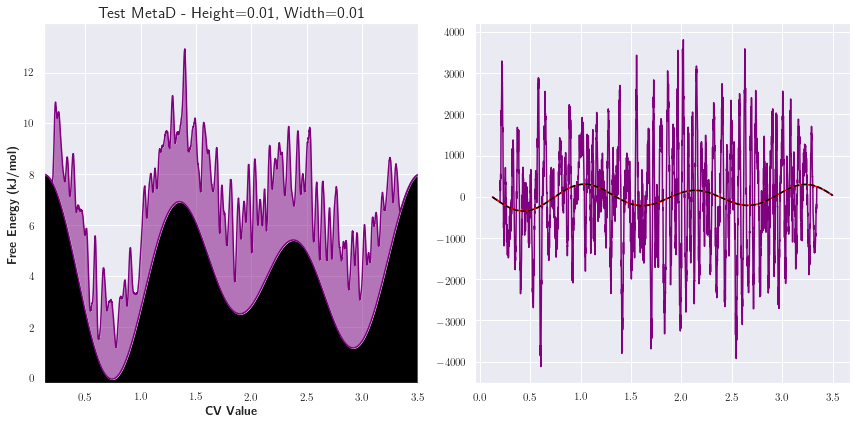

In [12]:
#Stress Test for bias deposition - continous kernel generation and bias deposition
np.set_printoptions(precision=4)

#Setting up grid of X values
min_val = 0.125
max_val = 3.5
valrange = max_val - min_val
increment = 0.001
npoints = int(valrange/increment)

x = np.linspace(min_val, max_val, npoints)
x = np.around(x, decimals=3)

#Build the triple well potential
A = [1.5, 1.8, 2]
a = 1.7
q = (2*math.pi)/a
potential = np.array([(A[0]*math.cos(q*x[i]) + A[1]*math.cos(1.5*q*x[i]) + A[2]*math.sin(1.5*q*x[i]) + 4) 
      for i in np.arange(0, len(x))])

delta_potential = [(-6*math.pi*(5*math.sin(q*x[i]) + 9*math.sin(1.5*q*x[i]) - 10*math.cos(1.5*q*x[i])))
             for i in np.arange(0, len(x))]

#Gaussian Kernel parameters
g_height, g_width = 0.01, 0.01

unbiased_pot = [(A[0]*math.cos(q*x[i]) + A[1]*math.cos(1.5*q*x[i]) + A[2]*math.sin(1.5*q*x[i]) + 4) 
      for i in np.arange(0, len(x))]

minval = [-0.2 for i in np.arange(0, len(x))]

#Simulated code snippet for gaussian kernel deposition in MetaD
for i in range(0, 1000):
    
    starting = round(random.uniform(0.2, 3.3), 3)
    print("step %d" % int(i+1))

    G_arr, g_length = gen_Gauss_Kernel(starting, g_height, g_width, increment)
    potential = deposit_Gauss_kernel(x, potential, G_arr, g_length)
    delta_pot = np.gradient(potential, 0.06*increment)
    
    delta_unbiased = np.gradient(unbiased_pot, 0.06*increment)
    
#Plotting the potential and the fixed starting point for the 1D MetaD simulation
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(121)

ax.set_title(r'Test MetaD - Height=' + str(g_height) + r', Width=' + str(g_width), fontsize=16)
ax.plot(x, potential, linestyle="-", color="purple")
ax.fill_between(x, unbiased_pot, potential, fc="purple", alpha=0.5)
ax.plot(x, unbiased_pot, linestyle="-", color="purple")
ax.plot(x, minval, "-", color="black")
ax.fill_between(x, minval, unbiased_pot, fc="black")
ax.set_xlabel(r'\textbf{CV Value}')
ax.set_ylabel(r'\textbf{Free Energy (kJ/mol)}')
ax.set_xlim(0.125, 3.5)
ax.set_ylim(-0.2, max(potential)+1)

ax_der = fig.add_subplot(122)

ax_der.plot(x, delta_pot, linestyle="-", color="purple")
ax_der.plot(x, delta_unbiased, linestyle="-", color="red")
ax_der.plot(x, delta_potential, linestyle="--" ,color="black")

fig.tight_layout()

plt.show()


(-0.2, 8.945734055261967)

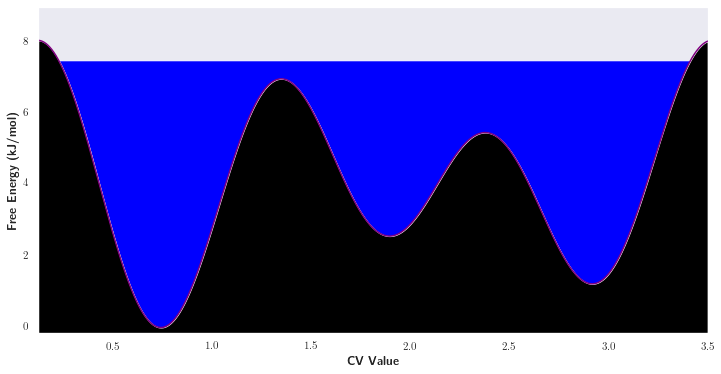

In [35]:
#Plotting the potential and the fixed starting point for the 1D MetaD simulation
sns.set_style("dark")

neg_unbiased_pot = [-1*(A[0]*math.cos(q*x[i]) + A[1]*math.cos(1.5*q*x[i]) + A[2]*math.sin(1.5*q*x[i]) + 4) 
      for i in np.arange(0, len(x))]

unbiased_pot = [(A[0]*math.cos(q*x[i]) + A[1]*math.cos(1.5*q*x[i]) + A[2]*math.sin(1.5*q*x[i]) + 4) 
      for i in np.arange(0, len(x))]

maxval = [max(potential)-1 for i in np.arange(0, len(x))]

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)

#ax.set_title(r'Test MetaD - Height=' + str(g_height) + r', Width=' + str(g_width), fontsize=16)
#ax.plot(x, potential, linestyle="-", color="purple")
#ax.fill_between(x, unbiased_pot, potential, fc="purple", alpha=0.5)
ax.plot(x, unbiased_pot, linestyle="-", color="purple")
#ax.plot(x, minval, "-", color="black")
ax.fill_between(x, unbiased_pot, maxval, fc="blue")
ax.fill_between(x, minval, unbiased_pot, fc="black")
ax.set_xlabel(r'\textbf{CV Value}')
ax.set_ylabel(r'\textbf{Free Energy (kJ/mol)}')
ax.set_xlim(0.125, 3.5)
ax.set_ylim(-0.2, max(potential)+0.5)

In [178]:
 #if np.allclose(G_arr[:,0], x[i:i+gauss_length], rtol=0.001, atol=0) == True:
        #print("Print at center - %0.3f, Index values of pot = %d:%d " % 
    #          (x[i+center_idx], i, i+gauss_length) )
        
    #    for idx, potval in enumerate(potential[i:i+gauss_length]):
    #        j = i+idx
            
    #        potential[j] = potval + G_arr[idx,1]
    #        print(G_arr[idx, 0], x[j])
            
    #    break   

In [ ]:
#Test - search and add gaussian to potential automatically 
#- To be tuned to have equal increments then implemented into AniMetaD

for i in range(0, len(x), gauss_length):
    center_idx = int(0.5*gauss_length)
    #if G_arr[center_idx,0] == x[i]:
    
    print(i, i+gauss_length, G_arr[:,0].shape, np.array(x[i:i+gauss_length]).shape)
    
    if np.allclose(G_arr[:,0], x[i:i+gauss_length], rtol=0.001, atol=0) == True:
        print("Print at center - %0.3f, Index values of pot = %d:%d " % 
              (x[i+center_idx], i, i+gauss_length) )
        
        for idx, potval in enumerate(potential[i:i+gauss_length]):
            j = i+idx
            
            potential[j] = potval + G_arr[idx,1]
            print(G_arr[idx, 0], x[j])
            
        break   

In [ ]:
"""
Velocity Verlet NVE MD Integrator for 1D simple harmonic well potential

V(x) = 0.5kx^2
F = -dV(x)/dx = -kx

"""

#Setting functions for calculation of forces, potential energy,

def calculate_force(x, k):
    return -k*x

def calc_potential(x, k):
    return 0.5*k*x**2

def calc_kinetic(v, mass):
    return 0.5*mass*v**2

def vupdate_positions(x, v, dt, stepf=1.0):
    return x + v*dt*stepf

def vupdate_velocities(v, F, mass, dt, stepfraction=1.0):
    # type: (object, object, object, object, object) -> object
    return v + (0.5*dt*stepfraction)*F

#Function for Velocity Verlet MD

def VelocityVerletIntegrator(x, v, MDSteps=1000, dt=0.1, mass=1.0, k=10):

    x_trj = np.zeros(MDSteps, dtype=np.float64)
    v_trj = np.zeros(MDSteps, dtype=np.float64)

    x_trj[0] = x
    v_trj[0] = v

    for step in range(1, MDSteps):

        f = calculate_force(x, k)
        v = vupdate_velocities(v, f, mass, dt, stepfraction=0.5)
        x = vupdate_positions(x, v, dt, stepf=1.0)
        f = calculate_force(x, k)
        v = vupdate_velocities(v, f, mass, dt, stepfraction=0.5)
        x_trj[step] = x
        v_trj[step] = v

        x_trj = np.array(x_trj)
        v_trj = np.array(v_trj)
        Epot = calc_potential(x_trj, k)
        Ekin = calc_kinetic(v_trj, mass)
        Etot = Epot+Ekin
        
        if (step % 100 == 0):
            print("Step %d - Potential = %f kJ/mol, Kinetic = %f kJ/mol, TOTAL = %f kJ/mol" 
                 % (step, Epot[step], Ekin[step], Etot[step]))

    return x_trj, v_trj, Epot, Ekin, Etot

x_0 = 1.0
v_0 = 1.0 #Saving initial velocities and coordinates to position and velocity vectors

MDSteps = int(1E04)
dt = 0.1

x, v, ep, ek, et = VelocityVerletIntegrator(x_0, v_0, MDSteps, dt, mass=1, k=10)

In [ ]:
#Plot trajectory of phase space for 1D oscillator

fig = plt.figure(figsize=(12,6)) 

ax1 = fig.add_subplot(121)

ax1.plot(x, v)
ax1.set_xlabel("x")
ax1.set_ylabel("v")

ax2 = fig.add_subplot(122)

dt = 0.01

time = np.linspace(0, MDSteps, MDSteps*dt)

ep_short = [ep[i] for i in np.arange(0, len(ep), int(1/dt))]
ek_short = [ek[i] for i in np.arange(0, len(ek), int(1/dt))]
et_short = [et[i] for i in np.arange(0, len(et), int(1/dt))]

ax2.plot(time, ep_short, color="green", label="Potential Energy")
ax2.plot(time, ek_short, color="blue", label="Kinetic Energy")
ax2.plot(time, et_short, color="red", label="Total Energy")
ax2.legend(loc="best")

fig.tight_layout()

plt.show()

In [ ]:

class MD_TriplePotential:
    
    """
    1D MD simulation over a triple well potential using the symplectic
    Velocity Verlet integrator
    
    Potential - V(x) 4 + 1.5cos(2pix/1.7) + 1.8cos(3pix/1.7) + 2sin(3pix/1.7)
    Force - F(x) = -dV(x)/dx = (6pi/17)(5sin(2pix/1.7) + 9sin(3pix/1.7) - 10cos(3pix/1.7))
    
    Starting coordinate fixed at 1.9, but is tunable
    """
    
    def __init__(self, x_i, v_i, n_steps, dt, mass=1.0):
    
        #Initialising arrays for x, v and energies
    
        x_trj = np.zeros(n_steps, dtype=np.float64)
        v_trj = np.zeros(n_steps, dtype=np.float64)
        
        x_trj[0] = x_i
        v_trj[0] = v_i
    
        Epot = np.zeros(n_steps, dtype=np.float64)
        Ekin = np.zeros(n_steps, dtype=np.float64)
        Etot = np.zeros(n_steps, dtype=np.float64)
    
        self.x_arr = x_trj
        self.v_arr = v_trj
        self.epot = Epot
        self.ekin = Ekin
        self.etot = Etot
        
        self.dt = dt
        self.mass = mass
    
    #Setting functions for calculation of forces, potential energy and kinetic energy

    def calc_Force(self, x, a=1.7):
        q = ((2*math.pi)/a)
    
        return (6*math.pi/17)*(5.0*math.sin(q*x) + 9.0*math.sin(1.5*q*x) - 10.0*math.cos(1.5*q*x))

    def calc_TriplePotential(self, x, a=1.7):
        q = ((2*math.pi)/a)
    
        return 4.0 + 1.5*math.cos(q*x) + 1.8*math.cos(1.5*q*x) + 2.0*math.sin(1.5*q*x)
    
    def calc_KineticEnergy(self, v):
        return 0.5*self.mass*(v**2)
    
    #Functions for performing Velocity Verlet integrations of positions and coordinates
    
    def VelocityVerletUpdate_position(self, x, v, stepf=1.0):
        return x + v*self.dt*stepf

    def VelocityVerletUpdate_velocity(self, v, F, stepf=1.0):
        return v + (0.5*self.dt*stepf)*F

    #Function for Velocity Verlet MD update

    def step(self, step):
        
        x = self.x_arr[step-1]
        v = self.v_arr[step-1]
        
        self.epot[step-1] = self.calc_TriplePotential(x)
        self.ekin[step-1] = self.calc_KineticEnergy(v)
        self.etot[step-1] = self.ekin[step-1]+self.epot[step-1]
        
        if (step % 1000 == 0):
            print("Step %d - X = %f \n Potential = %f kJ/mol, Kinetic = %f kJ/mol, TOTAL = %f kJ/mol" 
                 % (step, self.x_arr[step-1], self.epot[step-1], self.ekin[step-1], self.etot[step-1]))

        f = self.calc_Force(x)
        v = self.VelocityVerletUpdate_velocity(v, f, stepf=0.5)
        x = self.VelocityVerletUpdate_position(x, v, stepf=1.0)
        f = self.calc_Force(x)
        v = self.VelocityVerletUpdate_velocity(v, f, stepf=0.5)
        
        self.x_arr[step] = x
        self.v_arr[step] = v
        
    @property
    def get_outputs(self):
        return self.x_arr, self.v_arr, self.epot, self.ekin, self.etot
    
    @property
    def get_xarr(self):
        return self.x_arr
    
    @property
    def get_varr(self):
        return self.v_arr
    
    @property
    def get_epot(self):
        return self.epot
    
    @property
    def get_ekin(self):
        return self.ekin
    
    @property
    def get_etot(self):
        return self.etot

In [ ]:
#Running of MD_TriplePotential class instance

x_0 = 1.9
v_0 = 1.0 #Saving initial velocities and coordinates to position and velocity vectors

MDSteps = int(50000)
dt = 0.001

Test_VV3W = MD_TriplePotential(x_0, v_0, MDSteps, dt)
for i in range(1, MDSteps):
    Test_VV3W.step(i)
    
x, v, ep_trip, ek_trip, et_trip = Test_VV3W.get_outputs

#Plot trajectory of phase space for 1D oscillator

fig = plt.figure(figsize=(12,6)) 

ax1 = fig.add_subplot(121)

ax1.plot(x, v)
ax1.set_xlabel("x")
ax1.set_ylabel("v")

ax2 = fig.add_subplot(122)

time = np.linspace(0, MDSteps, MDSteps*dt)

ep_short = [ep_trip[i] for i in np.arange(0, len(ep_trip), int(1/dt))]
ek_short = [ek_trip[i] for i in np.arange(0, len(ek_trip), int(1/dt))]
et_short = [et_trip[i] for i in np.arange(0, len(et_trip), int(1/dt))]

ax2.plot(time, ep_short, color="green", label="Potential Energy")
ax2.plot(time, ek_short, color="blue", label="Kinetic Energy")
ax2.plot(time, et_short, color="red", label="Total Energy")
ax2.legend(loc="best")

fig.tight_layout()

plt.show()

In [ ]:
#Animated plot of the system state on the potential energy over the simulation time



#-----------------------------------------------------------------------------------
#Setup of MD_TriplePotential class instance

x_0 = 1.9
v_0 = 1.0 #Saving initial velocities and coordinates to position and velocity vectors

MDSteps = int(50000)
dt = 0.001

Test_VV3W = MD_TriplePotential(x_0, v_0, MDSteps, dt)
#-----------------------------------------------------------------------------------

# set up figure and animation

x = np.linspace(0.125, 3.5, 1000)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, autoscale_on=False,
                     xlim=(0.125, 3.5), ylim=(-0.1, 8.0))
ax.grid()

#Build the triple well potential
A = [1.5, 1.8, 2]
a = 1.7
q = (2*math.pi)/a
potential = [(A[0]*math.cos(q*x[i]) + A[1]*math.cos(1.5*q*x[i]) + A[2]*math.sin(1.5*q*x[i]) + 4) 
      for i in np.arange(0, len(x))]

ax.set_title(r'Test MetaD - Height=' + str(height) + r', Width=' + str(width), fontsize=16)
ax.plot(x, potential, linestyle="-", color="purple")
ax.set_xlabel(r'\textbf{CV Value}')
ax.set_ylabel(r'\textbf{Free Energy (kJ/mol)}')


point, = ax.scatter([], [], marker="o", color="blue")
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    point.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return point, time_text, energy_text

def animate(i):
    """perform animation step"""
    global Test_VV3W
    Test_VV3W.step(i)
    
    x_trj = Test_VV3W.get_xarr
    e_pot = Test_VV3W.get_epot

    point.set_data(*x_trj[i])
    time_text.set_text('X_Val = %.1f' % x_trj[i])
    energy_text.set_text('Energy = %.3f kJ/mol' % e_pot[i])
    return point, time_text, energy_text

# choose the interval based on dt and the time to animate one step
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)

ani = animation.FuncAnimation(fig, animate, frames=3000,
                              interval=interval, blit=True, init_func=init)

plt.show()
